In [154]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

import matplotlib.pyplot as plt
from PIL import Image
import glob
import numpy as np
import os
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

In [185]:
data_path = r'C:\Users\gjust\Documents\Github\data\caffe_drinks\detection\americano'
image_list = glob.glob(os.path.join(data_path, '*.jpg'))
target_list = glob.glob(os.path.join(data_path, '*.txt'))
for img, tar in list(zip(image_list, target_list))[:5]:
    print(img, tar)

C:\Users\gjust\Documents\Github\data\caffe_drinks\detection\americano\americano1.jpg C:\Users\gjust\Documents\Github\data\caffe_drinks\detection\americano\americano1.txt
C:\Users\gjust\Documents\Github\data\caffe_drinks\detection\americano\americano10.jpg C:\Users\gjust\Documents\Github\data\caffe_drinks\detection\americano\americano10.txt
C:\Users\gjust\Documents\Github\data\caffe_drinks\detection\americano\americano100.jpg C:\Users\gjust\Documents\Github\data\caffe_drinks\detection\americano\americano100.txt
C:\Users\gjust\Documents\Github\data\caffe_drinks\detection\americano\americano101.jpg C:\Users\gjust\Documents\Github\data\caffe_drinks\detection\americano\americano101.txt
C:\Users\gjust\Documents\Github\data\caffe_drinks\detection\americano\americano102.jpg C:\Users\gjust\Documents\Github\data\caffe_drinks\detection\americano\americano102.txt


In [255]:
cls_list = []
x_center, y_center = [], []
h_list, w_list = [], []
image_id = []
data = {}
for target in target_list:
    with open(target) as f:
        lines = f.readlines()
        
        for line in lines:
            line = line.strip().split()
            cls, coor = 3, list(map(float, line[1:]))
            cls_list.append(cls)
            
            x_center.append(coor[0])
            y_center.append(coor[1])
            w_list.append(coor[2])
            h_list.append(coor[3])
            
            image_id.append(target.split('\\')[-1].split('.')[0])

data['cls'] = cls_list
data['x_center'] = x_center
data['y_center'] = y_center
data['width'] = w_list
data['height'] = h_list
data['image_id'] = image_id

df = pd.DataFrame(data)
df.head()

,cls,x_center,y_center,width,height,image_id
0,3,0.470588,0.630243,0.852941,0.708609,americano1
1,3,0.263235,0.527451,0.467647,0.733333,americano10
2,3,0.727941,0.505882,0.467647,0.650980,americano10
3,3,0.426471,0.521212,0.529412,0.933333,americano100
4,3,0.513235,0.588300,0.879412,0.664459,americano101


In [367]:
def cvt_xyxy(coor_df, image_shape):
    x1 = (coor_df['x_center'] - coor_df['width']/2) * image_shape[0] # width
    y1 = (coor_df['y_center'] - coor_df['height']/2) * image_shape[1] # height
    
    x2 = (coor_df['x_center'] + coor_df['width']/2) * image_shape[0] # width
    y2 = (coor_df['y_center'] + coor_df['height']/2) * image_shape[1] # height
    
    data = {}
    data['x1'] = x1
    data['y1'] = y1
    data['x2'] = x2
    data['y2'] = y2
    
    new_df = pd.DataFrame(data)
    
    return new_df

In [377]:
data_path = r'C:\Users\gjust\Documents\Github\data\caffe_drinks\detection\americano\\'

class Drink_dataset(Dataset):
    def __init__(self, data_path, dataframe, train=True, transform=None):
        self.data_path = data_path
        self.dataframe = dataframe
        self.transform = transform
        self.image_ids = self.dataframe['image_id'].unique()
        self.train = train
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        img = Image.open(self.data_path + image_id + '.jpg')
        img_shape = img.size
        
        df = self.dataframe.loc[self.dataframe['image_id'] == image_id]
        df_xyxy = cvt_xyxy(df, img_shape)
    
        
        boxes = df_xyxy[['x1', 'y1', 'x2', 'y2']]
        boxes = torch.from_numpy(np.array(boxes)).type(torch.FloatTensor)
        
        labels = torch.from_numpy(np.array(df['cls'])).type(torch.int64)
        
        targets = {}
        targets['boxes'] = boxes
        targets['labels'] = labels
        
        if self.train:
            trans = self.transform['train']
            img = trans(img)
            
        else:
            trans = self.transform['test']
            img = trans(img)
            
        return img, targets            

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

transform = {
    'train' : transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(448),
        transforms.ToTensor()
    ]),
    
    'test' : transforms.Compose([
        transforms.ToTensor()
    ])
}

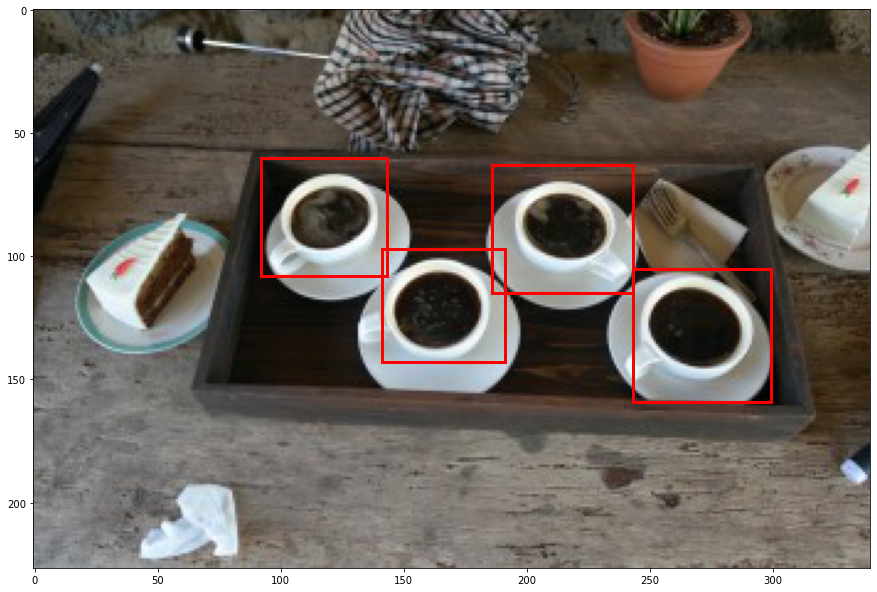

In [385]:
trainset = Drink_dataset(data_path, df, train=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, collate_fn = collate_fn)

sample, targets = iter(trainloader).next()
sample = sample[0].permute(1,2,0).numpy()
boxes = targets[0]['boxes']

fig, ax = plt.subplots(1,1, figsize=(15,15))

plt.imshow(sample)
for box in boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
plt.show()